# Auxilary Classifier GAN (ACGAN)

Referecnce : https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Use MNIST Dataset & DataLoader

In [3]:
bs =128

dataset = datasets.MNIST("./mnist", train=True, download=True, 
                         transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True)

torch.Size([128, 1, 32, 32]) tensor([6, 7, 5, 9, 7, 8, 7, 6, 2, 2, 9, 6, 8, 3, 3, 0, 9, 2, 8, 8, 6, 8, 2, 0,
        1, 7, 0, 0, 3, 6, 4, 9, 2, 2, 6, 5, 2, 7, 3, 1, 7, 2, 5, 0, 6, 0, 0, 2,
        6, 1, 1, 2, 7, 5, 5, 2, 3, 5, 4, 0, 3, 6, 3, 8, 5, 7, 1, 8, 0, 1, 9, 1,
        4, 0, 7, 8, 7, 7, 2, 0, 7, 8, 7, 4, 0, 8, 7, 3, 6, 6, 6, 5, 8, 5, 9, 1,
        3, 5, 1, 5, 3, 1, 6, 3, 2, 1, 9, 2, 0, 5, 8, 8, 2, 3, 9, 8, 0, 7, 5, 7,
        1, 1, 7, 5, 5, 8, 2, 0])


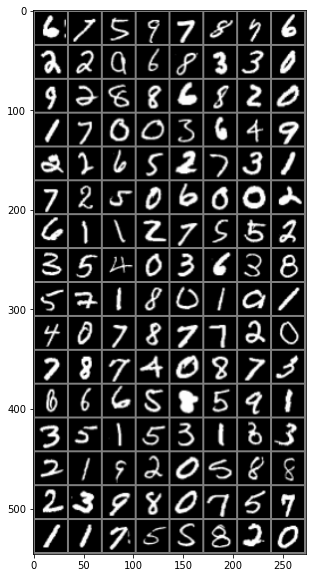

In [4]:
batch = next(iter(dataloader))
len(batch)
print(batch[0].shape, batch[1])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(batch[0]))

## Define Generator & Discriminator
### Generator architecture
input random vector: 100 dim
* Embedding: embeding labels to 100 dim
* Linear: out_features 128 * 8 * 8
* BatchNorm2d
* Upsample: scale_factor 2
* Conv2d: out_channel: 128, kernel size 3, stride 1, padding 1
* BatchNorm2d
* LeakyReLU: 0.2
* Upsample: scale_factor 2
* Conv2d: out_channel: 64, kernel size 3, stride 1, padding 1
* BatchNorm
* LeakyReLU: 0.2
* Conv2d: out_channel: 1, kernel size 3, stride 1, padding 1
* Tanh

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.emb = nn.Embedding(10, 100)
        self.fc = nn.Linear(100, 128*8*8)
        self.us = nn.Upsample(scale_factor=2)
        self.act = nn.LeakyReLU(0.2)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv1 = nn.Conv2d(128,128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,1, 3, 1, 1)
        self.last_act = nn.Tanh()
        
    def forward(self, z, labels):
        #### Implement Here ####
        # label.dim = (batch_size, 1)
        # embbeing_vec.dim = (batch_size, 100)
        ## noise, labels -> noise: 100, label: 1 dim -> 100 dim 
        ## noise * label
        embedding_vec = self.emb(labels)
        z = torch.mul(embedding_vec, z)
        z = self.fc(z)
        img = z.view(-1,128,8,8)
        img = self.conv1(self.us(self.bn1(img)))
        img = self.conv2(self.us(self.act(self.bn2(img))))
        img = self.conv3(self.act(self.bn3(img)))
        img = self.last_act(img)
        
        return img

### Discriminator architecture
input: [1 , 32 , 32] image  
* Conv2d: out_channel: 16, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* Conv2d: out_channel: 32, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 64, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 128, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* two linear layers: one for adversarial loss, one for classification
- Linear(Val) : output 1, activation : sigmoid
- Linear(classification) : output 10, no activation

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.block1 = self.make_block(1, 16, False)
        self.block2 = self.make_block(16, 32)
        self.block3 = self.make_block(32, 64)
        self.block4 = self.make_block(64, 128)
        self.val_act = nn.Sigmoid()
        self.val_fc = nn.Linear(128*2*2, 1)
        self.cl_fc = nn.Linear(128*2*2, 10)
        
    def make_block(self, in_channel, out_channel, bn= True):
        #### Implement Here ####
        layers = [
            nn.Conv2d(in_channel, out_channel, 3, 2, 1 ),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25)

        ]
        if bn:
            layers.append(nn.BatchNorm2d(out_channel))
        
        return nn.Sequential(*layers) 
        
        
    def forward(self, img):
        ## fill here
        img = self.block1(img)
        img = self.block2(img)
        img = self.block3(img)
        img = self.block4(img)
        x = img.view(img.size(0), -1)
        validity = self.val_act(self.val_fc(x)) #(bs, 1)
        labels = self.cl_fc(x) #(bs, 10)
        
        return validity, labels

In [15]:
G = Generator()

input_sample = torch.randn(4,100)
labels = torch.Tensor([0, 1, 2, 3]).long()
output = G(input_sample, labels)
output.shape

torch.Size([4, 1, 32, 32])

In [18]:
D = Discriminator()
validity, pred_label = D(output)
print(validity.shape)
print(pred_label.shape)
pred_label

torch.Size([4, 1])
torch.Size([4, 10])


tensor([[-0.3214,  0.7398,  0.4480, -0.4987, -0.2580, -0.8216,  0.1261, -0.0208,
          0.1118,  0.1754],
        [-0.0339,  0.0979,  0.7630, -0.7883,  0.6328, -0.2465,  0.0216,  0.2169,
          0.7866,  1.1533],
        [-1.1593, -0.1266, -1.1686,  0.5227, -0.0037,  0.0088,  0.0572,  0.3378,
          0.5578, -0.2497],
        [ 0.1256,  0.6550,  0.6069,  0.2254,  0.3258,  0.0764, -0.6005, -1.3171,
         -0.1709, -0.1406]], grad_fn=<AddmmBackward0>)

## Weight Initialization

In [19]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1: # Conv2d layer weights init
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1: # BatchNorm2d layer weights init
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# weight initialize
G.apply(weights_init_normal)
D.apply(weights_init_normal)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## Define loss & Optimizer & model

In [20]:
# Loss function
val_loss = torch.nn.BCELoss()
cl_loss = torch.nn.CrossEntropyLoss()

## optimizer fill here
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.00002, betas=(0.5, 0.9999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.00002, betas=(0.5, 0.9999))

## Start Training

In [21]:
G, D = G.to(device), D.to(device)
os.makedirs("./acgan_images", exist_ok=True)
epochs = 200

In [25]:
n_row = 10
labels = np.array([num for _ in range(n_row) for num in range(n_row)])
labels.reshape(10,10)

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [31]:
a = torch.tensor([[1,2,3],[4,5,6]])
torch.mul(a, a)

tensor([[ 1,  4,  9],
        [16, 25, 36]])

In [22]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.Tensor(np.random.normal(0, 1, (n_row ** 2, 100))).to(device)
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = torch.LongTensor(labels).to(device)
    gen_imgs = G(z, labels)
    save_image(gen_imgs, "acgan_images/%06d.png" % batches_done, nrow=n_row, normalize=True)
    imshow(torchvision.utils.make_grid(gen_imgs.cpu(), nrow = n_row))

[Epoch 0/200] [Batch 0/468] [D loss: 1.583395, acc: 8%] [G loss: 1.509462]


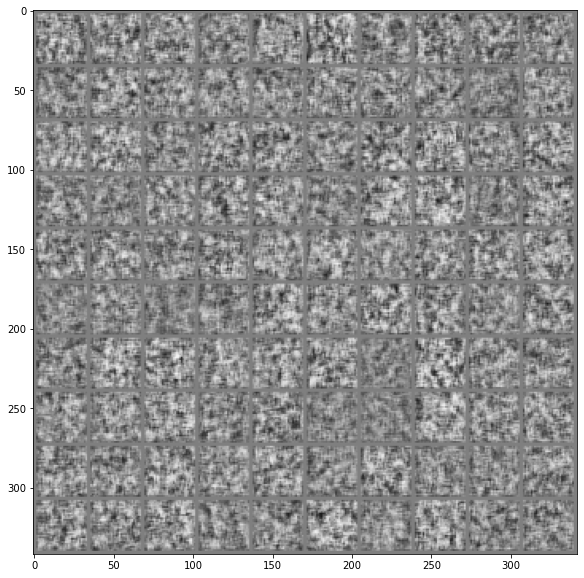

[Epoch 0/200] [Batch 100/468] [D loss: 1.574022, acc: 5%] [G loss: 1.593500]
[Epoch 0/200] [Batch 200/468] [D loss: 1.484361, acc: 14%] [G loss: 1.550703]
[Epoch 0/200] [Batch 300/468] [D loss: 1.466669, acc: 17%] [G loss: 1.554523]
[Epoch 0/200] [Batch 400/468] [D loss: 1.394122, acc: 26%] [G loss: 1.553139]
[Epoch 1/200] [Batch 32/468] [D loss: 1.294193, acc: 37%] [G loss: 1.451885]
[Epoch 1/200] [Batch 132/468] [D loss: 1.180409, acc: 43%] [G loss: 1.367189]
[Epoch 1/200] [Batch 232/468] [D loss: 1.042888, acc: 59%] [G loss: 1.169017]
[Epoch 1/200] [Batch 332/468] [D loss: 0.921085, acc: 66%] [G loss: 1.051418]
[Epoch 1/200] [Batch 432/468] [D loss: 0.779511, acc: 75%] [G loss: 0.836313]
[Epoch 2/200] [Batch 64/468] [D loss: 0.711954, acc: 82%] [G loss: 0.734042]
[Epoch 2/200] [Batch 164/468] [D loss: 0.659310, acc: 82%] [G loss: 0.713756]
[Epoch 2/200] [Batch 264/468] [D loss: 0.641976, acc: 83%] [G loss: 0.653953]
[Epoch 2/200] [Batch 364/468] [D loss: 0.542367, acc: 87%] [G loss:

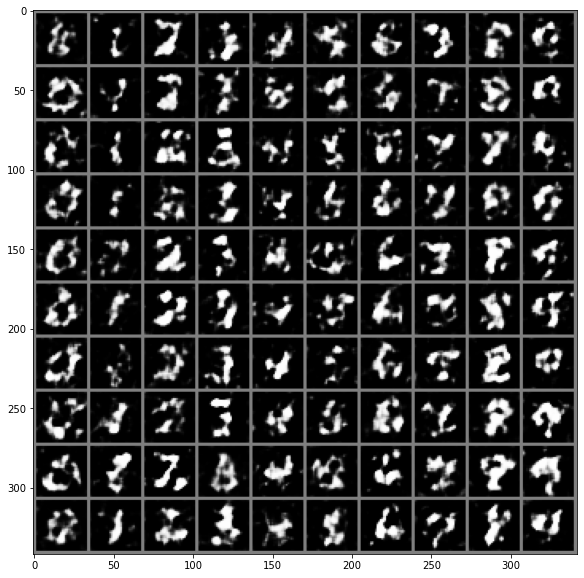

[Epoch 4/200] [Batch 228/468] [D loss: 0.472835, acc: 89%] [G loss: 0.527273]
[Epoch 4/200] [Batch 328/468] [D loss: 0.462820, acc: 91%] [G loss: 0.574304]
[Epoch 4/200] [Batch 428/468] [D loss: 0.504021, acc: 88%] [G loss: 0.506999]
[Epoch 5/200] [Batch 60/468] [D loss: 0.475764, acc: 90%] [G loss: 0.574275]
[Epoch 5/200] [Batch 160/468] [D loss: 0.474603, acc: 91%] [G loss: 0.524473]
[Epoch 5/200] [Batch 260/468] [D loss: 0.486890, acc: 87%] [G loss: 0.555057]
[Epoch 5/200] [Batch 360/468] [D loss: 0.472866, acc: 88%] [G loss: 0.502037]
[Epoch 5/200] [Batch 460/468] [D loss: 0.503384, acc: 89%] [G loss: 0.538554]
[Epoch 6/200] [Batch 92/468] [D loss: 0.532211, acc: 83%] [G loss: 0.540403]
[Epoch 6/200] [Batch 192/468] [D loss: 0.498953, acc: 89%] [G loss: 0.554031]
[Epoch 6/200] [Batch 292/468] [D loss: 0.488210, acc: 90%] [G loss: 0.568201]
[Epoch 6/200] [Batch 392/468] [D loss: 0.428349, acc: 94%] [G loss: 0.535244]
[Epoch 7/200] [Batch 24/468] [D loss: 0.465468, acc: 91%] [G loss:

KeyboardInterrupt: 

In [29]:
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):

        batch_size = real_imgs.shape[0]

        # Configure input
        real_imgs = real_imgs.to(device)
        real_labels = labels.to(device)
        
        ones = torch.ones((real_imgs.size(0), 1)).to(device)
        zeros = torch.zeros((real_imgs.size(0), 1)).to(device)
        
        ## z random sample
        ## label random sample 0-9 int
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, 100))).to(device)
        gen_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
        
        # -----------------
        #  Train Generator
        # -----------------
        #### Implement Here ####
        optimizer_G.zero_grad()
        ## generator, discriminator output
        fake_imgs = G(z, gen_labels)
        fake_pred_val, fake_pred_cl = D(fake_imgs)
        
        ## g_loss = adversarial_loss + classification loss
        adversarial_loss = val_loss(fake_pred_val, ones)
        classification_loss = cl_loss(fake_pred_cl, gen_labels)
        g_loss = (adversarial_loss + classification_loss) /2
        
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        #### Implement Here ####
        optimizer_D.zero_grad()
        
        # Loss for real images : adversarial_loss + classification loss
        real_pred_val, real_pred_cl = D(real_imgs)
        real_loss = (val_loss(real_pred_val, ones) + \
                     cl_loss(real_pred_cl, real_labels))/2

        # Loss for fake images : adversarial_loss + classification loss
        fake_pred_val, fake_pred_cl = D(fake_imgs.detach())
        fake_loss = (val_loss(fake_pred_val, zeros) + \
                    cl_loss(fake_pred_cl, gen_labels)) /2
        
        # Total discriminator loss
        d_loss = (real_loss + fake_loss) /2
        d_loss.backward()
        optimizer_D.step()
        
        # Calculate discriminator accuracy
        pred = np.concatenate([real_pred_cl.detach().cpu().numpy(), fake_pred_cl.detach().cpu().numpy()], axis=0)
        gt = np.concatenate([labels.detach().cpu().numpy(), gen_labels.detach().cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        batches_done = epoch * len(dataloader) + i
        if batches_done % 100 == 0:     
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
                % (epoch, 200, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
            )
            
        if batches_done % 2000 == 0:
            sample_image(n_row=10, batches_done=batches_done)